In [1]:
# Data manipulation
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split

# ML Classifier (Support Vector Machine & Logistic Regression)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Model Metrics
from sklearn.metrics import accuracy_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set pyplot style
plt.style.use('seaborn')

# Dimensionality Reduction
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

In [2]:
# Import dataset from datasets directory
ansur = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/ansur.csv')
ansur.head()

,Gender,weight_kg,stature_m,body_height
0,Male,81.5,1.776,69.92
1,Male,72.6,1.702,67.01
2,Male,92.9,1.735,68.31
3,Male,79.4,1.655,65.16
4,Male,94.6,1.914,75.35


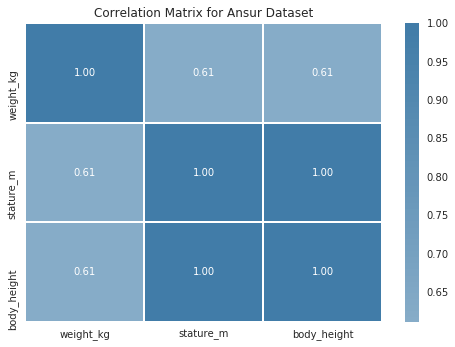

In [3]:
# Spot perfect correlation in data
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
sns.heatmap(ansur.corr(), center=0, cmap=cmap, linewidths=1, annot=True, fmt='.2f')
plt.title('Correlation Matrix for Ansur Dataset')
plt.show()

In [4]:
# Brute force removal of hightly correlated features
abs_corr_matrix = ansur.corr().abs()

# Upper triagule of corr matrix to false
mask = np.triu(np.ones_like(abs_corr_matrix, dtype=bool))
tri_df = abs_corr_matrix.mask(mask)

# Filter highly correlated dimensions
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]

# Drop highly correlated dimensions
reduced_df = ansur.drop(to_drop, axis=1)

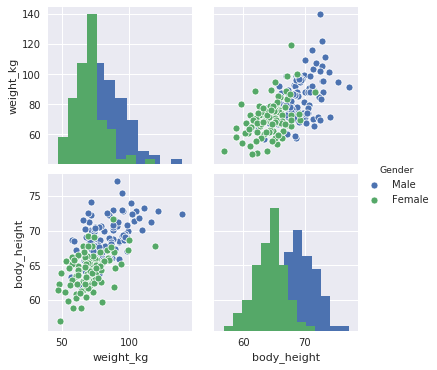

In [5]:
# Check visualization
sns.pairplot(reduced_df, hue='Gender', diag_kind='hist')
plt.show()

In [6]:
# High dimensional data import
body_dims = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/body_measurements.csv')
body_dims.drop('ID', axis=1, inplace=True)
print(f'Number of dimensions (cols): {len(body_dims.columns)}')

Number of dimensions (cols): 94


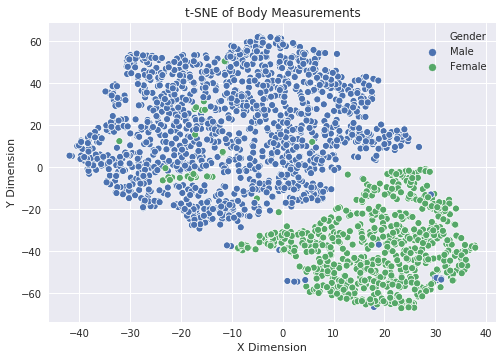

In [7]:
# Instanciate TSNE Model
tsne_model = TSNE(learning_rate=50)

# Fit and transform numeric data from 4th column
tsne_features = tsne_model.fit_transform(body_dims.iloc[:, 4:])

# Add components to df
body_dims['x'] = tsne_features[:, 0]
body_dims['y'] = tsne_features[:, 1]

# Plot transformed data
sns.scatterplot(x='x', y='y', hue='Gender', data=body_dims)
plt.xlabel('X Dimension')
plt.ylabel('Y Dimension')
plt.title('t-SNE of Body Measurements')
plt.show()

In [8]:
# Predict 'Gender' based on all body measurements
y = body_dims['Gender']
X = body_dims.drop(['Branch', 'Component', 'Gender', 'x', 'y'], axis=1)

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC()
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')


acc_train = 0.9714285714285714
acc_test = 0.9666666666666667


In [9]:
# Predict Gender based on 'neckcircumferencebase' feature 
y = body_dims['Gender']
X = body_dims[['neckcircumferencebase']]

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC()
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')

acc_train = 0.9342857142857143
acc_test = 0.9316666666666666


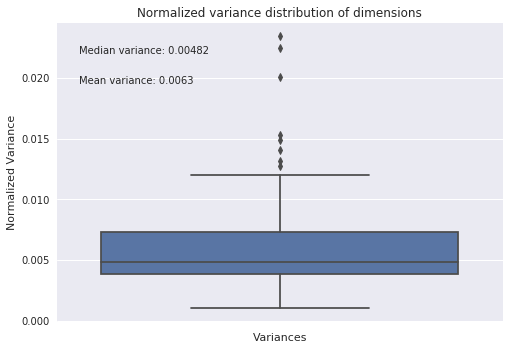

In [10]:
# Study the distribution of the variances from all dimensions from body_dims

# Normalize columns for better visualization
numeric_dims = body_dims.iloc[:, 3:-2] / body_dims.iloc[:, 3:-2].mean()

# Calculate variances, median and mean
vars = numeric_dims.std() ** 2
median = round(vars.quantile(), 5)
mean = round(vars.mean(), 5)

# Plot variance distribution and annotate
sns.boxplot(y=vars.values)
plt.annotate(f'Median variance: {median}', (-0.45, 0.022))
plt.annotate(f'Mean variance: {mean}', (-0.45, 0.0195))

plt.xlabel('Variances')
plt.ylabel('Normalized Variance')
plt.title('Normalized variance distribution of dimensions')
plt.show()


In [11]:
# Reduce dimensionality with a variance threshold (median variance)
variance_selection = VarianceThreshold(threshold=0.00482)

# Fit variance selector
variance_selection.fit(numeric_dims)

# Get variance mask
mask = variance_selection.get_support()

# Reduced body_dims
reduced_body = numeric_dims.loc[:, mask]

# New number of dimensions
print(f'Old dimensions: {len(body_dims.columns)}')
print(f'New dimensions: {len(reduced_body.columns)}')

Old dimensions: 96
New dimensions: 45


In [12]:
# Predict Gender based on reduced dataset
y = body_dims['Gender']
X = reduced_body

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC(C=0.1)
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')

acc_train = 0.9978571428571429
acc_test = 1.0


In [13]:
# Predict Gender with a classifier less prone to overfit (simpler model)
log_reg = LogisticRegression(solver='newton-cg', C=0.1)

# Fit Model
log_reg.fit(X_train, y_train)

# Measure Accuracy
acc_train = accuracy_score(y_train, log_reg.predict(X_train))
acc_test = accuracy_score(y_test, log_reg.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')

acc_train = 0.9778571428571429
acc_test = 0.98


In [14]:
# Create DataFrame of dimensions and coefficients
lr_coefs = dict(zip(reduced_body.columns, np.abs(log_reg.coef_[0])))

# Sort by most important coefficients
lr_coefs = sorted(lr_coefs.items(), key=lambda x: x[1], reverse=True)
pd.Series(dict(lr_coefs[:5]))

neckcircumference             1.585882
lateralmalleolusheight        1.355611
neckcircumferencebase         1.322256
hipbreadthsitting             1.217004
forearmcircumferenceflexed    1.155597
dtype: float64

In [15]:
# Recursive Feature Elimination
rfe = RFE(estimator=log_reg, n_features_to_select=1)

# Fit RFE with model
rfe.fit(X_train, y_train)

# Rank features
feature_ranking = dict(zip(X.columns, rfe.ranking_))

# Sort ranking from less to most important
sorted_features = dict(sorted(feature_ranking.items(), key=lambda x: x[1], reverse=True))

# Order DataFrame
ranking_df = reduced_body[sorted_features.keys()]

# Declare X, y
X, y = ranking_df, body_dims['Gender']


#### Iterate over ordered columns and test accuracy of Logistic Regression

In [17]:
# Save accuracy scores
accuracy = []

# Iterate over all models
for i in range(len(sorted_features)):

    # Train Test Split with ordered features
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, i:], y, train_size=0.7, random_state=12)

    # Train model with those features
    log_reg.fit(X_train, y_train)

    # Measure accuracy
    train_acc = accuracy_score(y_train, log_reg.predict(X_train))
    test_acc = accuracy_score(y_test, log_reg.predict(X_test))
    accuracy.append([len(X_train.columns), train_acc, test_acc])

## Plot accuracy scores for every RFE selection

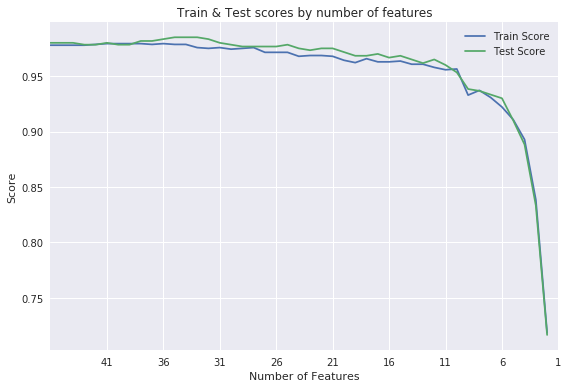

In [18]:
# Extract accuracy data from experiment
accuracy = np.array(accuracy)
features, train, test = np.split(accuracy, 3, axis=1)
features = features.flatten().astype('int')

# Plot lines of training adn testing accuracy
plt.plot(train, label='Train Score')
plt.plot(test, label='Test Score')
plt.xticks(features[::5], features[::-5])

# Annotate figure
plt.title('Train & Test scores by number of features')
plt.ylabel('Score')
plt.xlabel('Number of Features')

# Figure style and legend
plt.xlim(0, 45)
plt.tight_layout()
plt.legend()
plt.show()